Definition from ChatGPT: 

![alternative text](../../data/linear_regression_chatgpt.png)


In [1]:
from torch import nn
import torch
import numpy as np
from matplotlib.pylab import plt
from torch.utils.data import Dataset, DataLoader

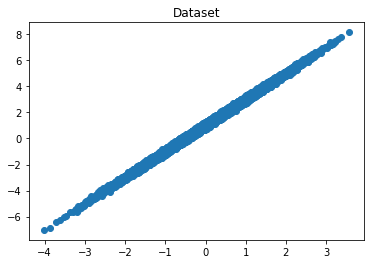

In [5]:
X = torch.randn(15000, 1)
gW = 2 
gb = 1
Y = gW * X + gb + (torch.randn(15000, 1)/10)

plt.scatter(X,Y)
plt.title("Dataset")
plt.show()

In [6]:
class CustomDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X.clone().detach()
        self.Y = Y.clone().detach()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    


In [7]:
# Splitting dataset 
dataset = CustomDataset(X,Y)

train_size  = int(len(X) * 0.9 )
valid_test_size  = int(0.1*len(X))

train_dataset, valid_test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_test_size])
valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, [valid_test_size//2, valid_test_size//2])


batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


In [9]:
# let's make this a function 

def dataset(X,Y, batch_size = 32):
    dataset = CustomDataset(X,Y)
    train_size  = int(len(X) * 0.9 )
    valid_test_size  = int(0.1*len(X))

    train_dataset, valid_test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_test_size])
    valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, [valid_test_size//2, valid_test_size//2])


    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    
    return train_data_loader, valid_data_loader, test_dataset

In [10]:
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        
        self.linear = nn.Linear(1,1)
    
    def forward(self, x ): 
        return self.linear(x) 

In [11]:
model = LinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

train_losses = []
val_losses   = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_data_loader:
        optimizer.zero_grad()
        output = model(inputs) # forward prop
        loss = criterion(output,labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_losses.append(train_loss/len(train_data_loader))
        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_input, val_labels in valid_data_loader:
            output = model(val_input) # forward prop
            val_loss += criterion(output,val_labels).item()
            
        val_losses.append(val_loss/len(valid_data_loader))
    
    if (epoch + 1)%10==0:
        print(f'epoch {epoch+1}, train loss:{train_losses[-1]:.4f} , valid loss:{val_losses[-1]:.4f}')
    


2024-06-06 19:42:29.594107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch 10, train loss:0.0099 , valid loss:0.0095
epoch 20, train loss:0.0099 , valid loss:0.0096


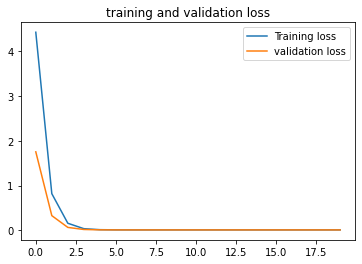

In [12]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("training and validation loss")
plt.legend(["Training loss","validation loss"])
plt.show()

Let's encapsulate our training pipeline, we're gonna it a few times 

In [13]:
model = LinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
num_epochs = 20

def training(train_data_loader,valid_data_loader, criterion, optimizer,num_epochs ):
    train_losses = []
    val_losses   = []


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_data_loader:
            optimizer.zero_grad()
            output = model(inputs) # forward prop
            loss = criterion(output,labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss/len(train_data_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_input, val_labels in valid_data_loader:
                output = model(val_input) # forward prop
                val_loss += criterion(output,val_labels).item()

            val_losses.append(val_loss/len(valid_data_loader))

        if (epoch + 1)%10==0:
            print(f'epoch {epoch+1}, train loss:{train_losses[-1]:.4f} , valid loss:{val_losses[-1]:.4f}')
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title("training and validation loss")
    plt.legend(["Training loss","validation loss"])
    plt.show()


In [14]:
Xs = []
ys = []
preds = []
for x,y in test_dataset:
    with torch.no_grad():
        pred = model(x).detach().numpy()
        Xs.append(x.detach().numpy())
        ys.append(y.detach().numpy())
        preds.append(pred)


let's make this a function as well:

In [15]:
def testing(test_dataset):
    Xs = []
    ys = []
    preds = []
    for x,y in test_dataset:
        with torch.no_grad():
            pred = model(x).detach().numpy()
            Xs.append(x.detach().numpy())
            ys.append(y.detach().numpy())
            preds.append(pred)

    plt.scatter(Xs,ys)
    plt.scatter(Xs,preds)
    plt.title("Ground Truth vs Fitted Line")
    plt.legend(["ground truth","fitted line"])
    plt.show()

In [16]:
params = model.parameters()
w = next(params).detach().squeeze().numpy()
b = next(params).detach().squeeze().numpy()
print(f'true w: {gW:.4f} and true b: {gb:.4f}')
print(f'estimated w: {w:.4f} and estimated b: {b:.4f}')

true w: 2.0000 and true b: 1.0000
estimated w: -0.4390 and estimated b: 0.9102


# Now let's try making the non-linear 
Linear regression is not gonna make it here. But, let's see what happens. 

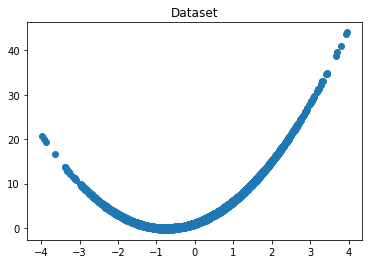

In [17]:
X = torch.randn(15000, 1)
gW1 = 2 
gW2 = 3 

gb = 1
Y = gW1 * X**2 + gW2 * X + gb + (torch.randn(15000, 1)/10)

plt.scatter(X,Y)
plt.title("Dataset")
plt.show()

epoch 10, train loss:8.0267 , valid loss:7.5709
epoch 20, train loss:8.0290 , valid loss:7.9937


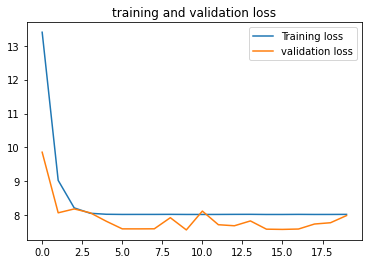

In [18]:
# Splitting dataset 
train_data_loader, valid_data_loader, test_dataset = dataset(X,Y)
model = LinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
num_epochs = 20

training(train_data_loader, valid_data_loader , criterion, optimizer,num_epochs )

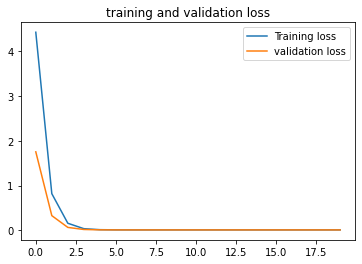

In [19]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("training and validation loss")
plt.legend(["Training loss","validation loss"])
plt.show()

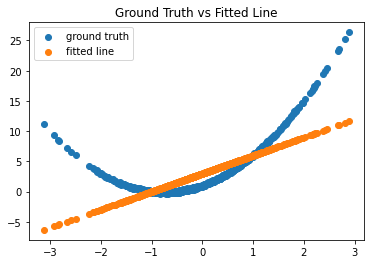

In [20]:
testing(test_dataset)

Let's introduce more layers... Linear of linear is still Linear

In [21]:
class MulitLinearRegression(nn.Module):
    
    def __init__(self):
        super(MulitLinearRegression, self).__init__()
        
        self.linear1 = nn.Linear(1,20)
        self.linear2 = nn.Linear(20,1)
    
    def forward(self, x ): 
        x1 = self.linear1(x) 
        y = self.linear2(x1) 
        return y

epoch 10, train loss:8.0453 , valid loss:7.7242
epoch 20, train loss:8.0442 , valid loss:7.6380


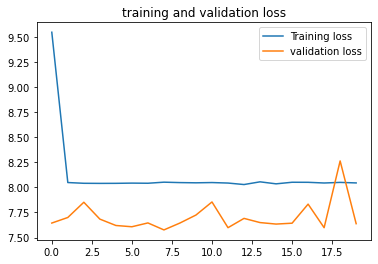

In [22]:
# Splitting dataset 
model = MulitLinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
num_epochs = 20
training(train_data_loader, valid_data_loader, criterion, optimizer,num_epochs )

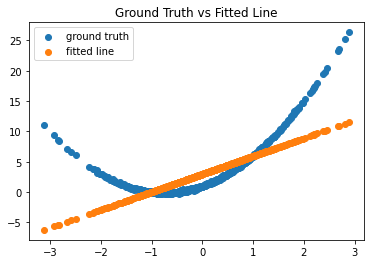

In [23]:
testing(test_dataset)

 As expected, increasing the parameters of the model without introducing non-linearity didn't solve the non-linearity in our dataset.

So, let's introduce non-linearity in our model. 

In [24]:
class NonLinearRegression(nn.Module):
    
    def __init__(self):
        super(NonLinearRegression, self).__init__()
        
        self.linear1 = nn.Linear(1,20)
        self.linear2 = nn.Linear(20,1)
        self.relu = nn.ReLU()
    
    def forward(self, x ): 
        x1 = self.relu(self.linear1(x))
        y = self.linear2(x1) 
        return y
    

epoch 10, train loss:0.5077 , valid loss:0.3668
epoch 20, train loss:0.2611 , valid loss:0.1733


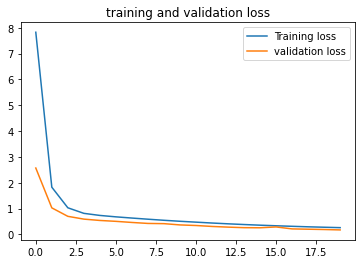

In [25]:
# Splitting dataset 
model = NonLinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
num_epochs = 20
training(train_data_loader, valid_data_loader, criterion, optimizer,num_epochs )

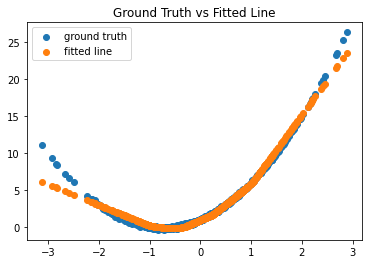

In [27]:
testing(test_dataset)

Let's make the dataset a little more difficult 

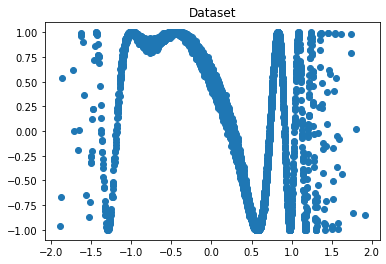

In [28]:
X = torch.randn(15000, 1)/2
gW1 = 4 
gW2 = 3
gW3 = 2

gb = 1
Y = np.cos(gW1 * X**4+ gW2 * X**3 + gW3 * X + gb + (torch.randn(15000, 1)/20))

plt.scatter(X,Y)
plt.title("Dataset")
plt.show()

epoch 10, train loss:0.1700 , valid loss:0.1783
epoch 20, train loss:0.1584 , valid loss:0.1625
epoch 30, train loss:0.1380 , valid loss:0.1396
epoch 40, train loss:0.1239 , valid loss:0.1257
epoch 50, train loss:0.1145 , valid loss:0.1158
epoch 60, train loss:0.1063 , valid loss:0.1179
epoch 70, train loss:0.0993 , valid loss:0.0995
epoch 80, train loss:0.0936 , valid loss:0.0939
epoch 90, train loss:0.0891 , valid loss:0.0889
epoch 100, train loss:0.0856 , valid loss:0.0855
epoch 110, train loss:0.0829 , valid loss:0.0827
epoch 120, train loss:0.0810 , valid loss:0.0834
epoch 130, train loss:0.0794 , valid loss:0.0804
epoch 140, train loss:0.0782 , valid loss:0.0769
epoch 150, train loss:0.0772 , valid loss:0.0761


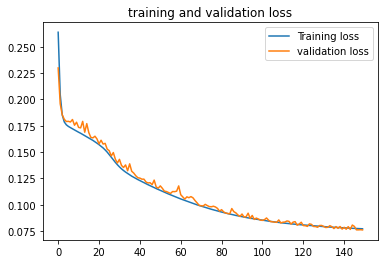

In [29]:
# Splitting dataset 
train_data_loader, valid_data_loader, test_dataset = dataset(X,Y)
model = NonLinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
num_epochs = 150
training(train_data_loader, valid_data_loader, criterion, optimizer,num_epochs )

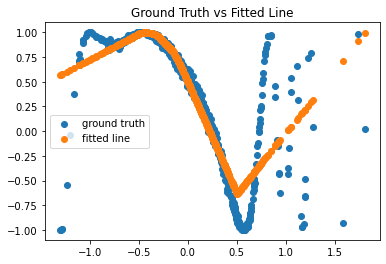

In [30]:
testing(test_dataset)

As you saw the training loss had a hard time going below 6, so we might want to make our model a bit deeper and bigger

In [31]:
class DeepNonLinearRegression(nn.Module):
    
    def __init__(self):
        super(DeepNonLinearRegression, self).__init__()
        
        self.linear1 = nn.Linear(1,64)
        self.linear2 = nn.Linear(64,128)
        self.linear3 = nn.Linear(128,1)
        self.relu = nn.ReLU()
    
    def forward(self, x ): 
        x1 = self.relu(self.linear1(x))
        x2 = self.relu(self.linear2(x1))
        y = self.linear3(x2) 
        return y
    

epoch 10, train loss:0.1512 , valid loss:0.1594
epoch 20, train loss:0.1318 , valid loss:0.1398
epoch 30, train loss:0.1162 , valid loss:0.1232
epoch 40, train loss:0.1031 , valid loss:0.1067
epoch 50, train loss:0.0931 , valid loss:0.0963
epoch 60, train loss:0.0860 , valid loss:0.0888
epoch 70, train loss:0.0810 , valid loss:0.0842
epoch 80, train loss:0.0773 , valid loss:0.0808
epoch 90, train loss:0.0743 , valid loss:0.0752
epoch 100, train loss:0.0722 , valid loss:0.0748
epoch 110, train loss:0.0705 , valid loss:0.0732
epoch 120, train loss:0.0692 , valid loss:0.0698
epoch 130, train loss:0.0679 , valid loss:0.0695
epoch 140, train loss:0.0668 , valid loss:0.0670
epoch 150, train loss:0.0657 , valid loss:0.0657
epoch 160, train loss:0.0646 , valid loss:0.0660
epoch 170, train loss:0.0633 , valid loss:0.0636
epoch 180, train loss:0.0619 , valid loss:0.0637
epoch 190, train loss:0.0607 , valid loss:0.0611
epoch 200, train loss:0.0596 , valid loss:0.0617
epoch 210, train loss:0.0586 

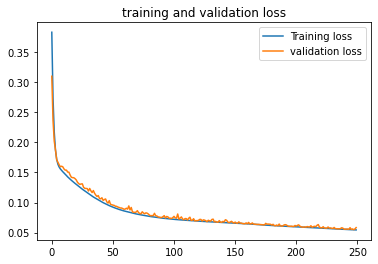

In [32]:
# Splitting dataset 
train_data_loader, valid_data_loader, test_dataset = dataset(X,Y)
model = DeepNonLinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0005)
num_epochs = 250
training(train_data_loader, valid_data_loader, criterion, optimizer,num_epochs )

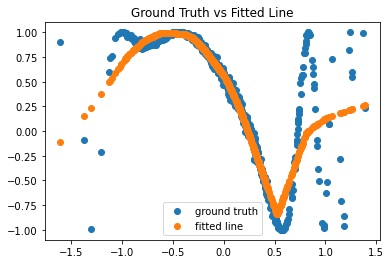

In [33]:
testing(test_dataset)